In [17]:
from __future__ import print_function, division
import warnings
# warnings.filterwarnings("ignore")
import os
# os.system("pip install pandas")
# os.system("pip install torchvision")
import os.path
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import dlib
# import argparse
# from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from PIL import Image

In [27]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)


def detect_faces(input_dir, detections_dir, default_size=300, size=300, padding = 0.25): # default_max_size=800
    image_paths = [f"{input_dir}/{f}" for f in os.listdir(input_dir)]

    cnn_face_detector = dlib.cnn_face_detection_model_v1('dlib_models/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('dlib_models/shape_predictor_5_face_landmarks.dat')

    for index, image_path in tqdm(enumerate(image_paths), desc="Detecting faces (manually)"):
        # if index < min_index or index > max_index:
        #     continue

        img = dlib.load_rgb_image(image_path)
        
        old_height, old_width, _ = img.shape

        if old_width > old_height:
            new_width, new_height = default_size, int(default_size * old_height / old_width)
        else:
            new_width, new_height =  int(default_size * old_width / old_height), default_size

        # assert old_width >= old_height
        # new_width = default_size * int(old_width / old_height)
        # new_height = default_size

        img = dlib.resize_image(img, rows=new_height, cols=new_width)

        dets = cnn_face_detector(img, 1)

        num_faces = len(dets)
        if num_faces == 0:
            print("Sorry, there were no faces found in '{}'".format(image_path))
            continue
        # Find the 5 face landmarks we need to do the alignment.
        
        faces = dlib.full_object_detections()
        
        for detection in dets:
            rect = detection.rect
            faces.append(sp(img, rect))
        images = dlib.get_face_chips(img, faces, size=size, padding = padding)
        for idx, image in enumerate(images):
            img_name = image_path.split("/")[-1]
            # path_sp = img_name.split(".")
            # face_name = os.path.join(detections_dir,  path_sp[0] + "_" + "face" + str(idx) + "." + path_sp[-1])
            face_name = detections_dir + img_name
            dlib.save_image(image, face_name)


def detect_faces_from_bbox(aug_images_dir, bboxes_path, detections_dir):
    
    crops = pd.read_csv(bboxes_path)[["Left", "Top", "Right", "Bottom"]].values
    default_size = 300

    # iterate through all images specified
    img_names = [x for x in os.listdir(aug_images_dir)]
    for img_name in tqdm(img_names, desc="Detecting images (bboxes)"):
        original_img_nmb = int(img_name.split("_")[0])
        image = Image.open(aug_images_dir + img_name)
        image = image.crop(crops[original_img_nmb - 1])
        old_width, old_height = image.size

        if old_width > old_height:
            new_width, new_height = default_size, int(default_size * old_height / old_width)
        else:
            new_width, new_height =  int(default_size * old_width / old_height), default_size
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        # print(image.size)
        # image.show()
        image.save(detections_dir + img_name)
    #     # break



def predict_age_gender_race(save_prediction_at, imgs_path, score_precision=3, append=False, device="cuda:0"):
    img_names = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path)]

    model_fair_7 = torchvision.models.resnet34(weights="DEFAULT")
    model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
    model_fair_7.load_state_dict(torch.load('fair_face_models/res34_fair_align_multi_7_20190809.pt', map_location="cpu"))#fair_face_models/fairface_alldata_7race_20191111.pt
    model_fair_7 = model_fair_7.to(device)
    model_fair_7.eval()

    # model_fair_4 = torchvision.models.resnet34(weights="DEFAULT")
    # model_fair_4.fc = nn.Linear(model_fair_4.fc.in_features, 18)
    # model_fair_4.load_state_dict(torch.load('fair_face_models/res34_fair_align_multi_4_20190809.pt', map_location="cpu"))#fair_face_models/fairface_alldata_4race_20191111.pt
    # model_fair_4 = model_fair_4.to(device)
    # model_fair_4.eval()

    trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # img pth of face images
    face_names = []
    # list within a list. Each sublist contains scores for all races. Take max for predicted race
    race_scores_fair = []
    gender_scores_fair = []
    age_scores_fair = []
    race_score_goal = []
    race_preds_fair = []
    gender_preds_fair = []
    age_preds_fair = []
    # race_scores_fair_4 = []
    # race_preds_fair_4 = []

    for img_name in tqdm(img_names, desc="Predicting"):
        
        short_name = img_name.split("/")[-1]
        wanted_race = int(short_name.split("_")[1])

        face_names.append(short_name)
        image = dlib.load_rgb_image(img_name)
        image = trans(image)
        image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
        image = image.to(device)

        # fair
        outputs = model_fair_7(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)

        race_outputs = outputs[:7]

        # reorder race outputs
        reordered_race_outputs = []
        reordered_race_outputs.append(race_outputs[1])
        reordered_race_outputs.append(race_outputs[5])
        reordered_race_outputs.append(race_outputs[2])
        reordered_race_outputs.append(race_outputs[6])
        reordered_race_outputs.append(race_outputs[4])
        reordered_race_outputs.append(race_outputs[3])
        reordered_race_outputs.append(race_outputs[0])

        race_outputs = reordered_race_outputs
        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]

        race_score = np.round(np.exp(race_outputs) / np.sum(np.exp(race_outputs)), score_precision)
        race_score_goal.append(race_score[wanted_race])
        gender_score = np.round(np.exp(gender_outputs) / np.sum(np.exp(gender_outputs)), score_precision)
        age_score = np.round(np.exp(age_outputs) / np.sum(np.exp(age_outputs)), score_precision)

        race_pred = np.argmax(race_score)
        gender_pred = np.argmax(gender_score)
        age_pred = np.argmax(age_score)

        race_scores_fair.append(race_score)
        gender_scores_fair.append(gender_score)
        age_scores_fair.append(age_score)

        race_preds_fair.append(race_pred)
        gender_preds_fair.append(gender_pred)
        age_preds_fair.append(age_pred)

        # fair 4 class
        # outputs = model_fair_4(image)
        # outputs = outputs.cpu().detach().numpy()
        # outputs = np.squeeze(outputs)

        # race_outputs = outputs[:4]
        # race_score = np.round(np.exp(race_outputs) / np.sum(np.exp(race_outputs)), score_precision)
        # race_pred = np.argmax(race_score)

        # race_scores_fair_4.append(race_score)
        # race_preds_fair_4.append(race_pred)

    result = pd.DataFrame([face_names,
                           race_preds_fair,
                        #    race_preds_fair_4,
                           gender_preds_fair,
                           age_preds_fair,
                           race_score_goal,
                           race_scores_fair, 
                        #    race_scores_fair_4,
                           gender_scores_fair,
                           age_scores_fair, 
                           ]).T

    result.columns = ['Image_Name',
                      'Race',
                    #   'Race_4',
                      'Gender',
                      'Age',
                      'Race_Score_Goal',
                      'Race_Scores',
                    #   'Race_Scores_4',
                      'Gender_Scores',
                      'Age_Scores'
                      ]

    races = ['Black', 'Indian', 'Latino', 'Middle Eastern', 'Southeast Asian', 'East Asian', 'White']
    for i, race in enumerate(races):
        result.loc[result['Race'] == i, 'Race'] = race
    
    # race fair 4
    # races_4 = ['White', 'Black', 'Asian', 'Indian']
    # for i, race in enumerate(races_4):
    #     result.loc[result['Race_4'] == i, 'Race_4'] = race

    # gender
    result.loc[result['Gender'] == 0, 'Male'] = 1
    result.loc[result['Gender'] == 1, 'Male'] = 0

    # age
    ages = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
    for i, age in enumerate(ages):
        result.loc[result['Age'] == i, 'Age'] = age

    result = result.sort_values("Image_Name")

    # pick out which columns you want to save
    result = result[['Image_Name',
            'Race', 
            # 'Race_4',
            'Gender', 
            # 'Age',
            'Race_Score_Goal',
            'Race_Scores',
            # 'Race_Scores_4',
            'Gender_Scores'
            # 'Age_Scores'
            ]]
    result.to_csv(save_prediction_at, index=False, mode="a" if append else "w")

    print(f"Saved results at '{save_prediction_at}'")


def prepare_prediction(input_dir, detections_dir, bboxes_path, use_bboxes, prediction_dir, only_predict):
    
    # detections should already be prepared
    if only_predict:
        if not os.path.exists(detections_dir):
            raise Exception(f"There are no detections to predict at '{detections_dir}'!")
        else:
            print(f"Detected faces found at '{detections_dir}'.")
    
    # detections have to be created from the inserted image(s) first
    else:
        if not os.path.exists(input_dir):
            raise Exception(f"There are no images to detect faces at '{input_dir}'!")

        else:
            # clear detections directory if necessary
            if os.path.exists(detections_dir):
                os.system(f"rm -r {detections_dir}")
            os.makedirs(detections_dir)

            # detect faces
            if use_bboxes: 
                detect_faces_from_bbox(input_dir, bboxes_path, detections_dir)
            else:
                detect_faces(input_dir, detections_dir)
            
            print(f"Detected faces saved at '{detections_dir}'.")

    # ensure directory for prediction exists
    if not os.path.exists(prediction_dir):
        os.makedirs(prediction_dir)
    

def get_image_number(detections_dir):
    detected_faces = [f for f in os.listdir(detections_dir)]
    return detected_faces[0].split(".")[0].split("_")[0]



dlib.DLIB_USE_CUDA = True

In [19]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--csv', dest='input_csv', action='store',
#                     help='csv file of image path where col name for image path is "img_path')
# args = parser.parse_args()
# imgs = pd.read_csv(args.input_csv)['img_path']
# imgs = pd.read_csv(input_csv)['img_path']

In [28]:
# pick device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# pick directories
input_dir = "../CelebA/aug_precise_prompts_strong/"
detections_dir = "detected_faces/CelebA_10k_aug_precise_prompts/"
prediction_dir = "outputs"

# print(f"Interval: {(min_index, max_index)}")

# do you want to predict or detect faces first?
only_predict = True

# do you want to fasten the face detection using bounding boxes?
bboxes_path = "../CelebA/augmentations/bboxes_cropped/448_px_first_10k.csv"
use_bboxes = True

# prepare the prediction
prepare_prediction(input_dir, detections_dir, bboxes_path, use_bboxes, prediction_dir, only_predict)

# create prediction file name
# img_name = get_image_number(detections_dir)
output_csv = f"{prediction_dir}/train_aug_10k_precise_predictions.csv"   # {img_name}_mytest.csv"

# do you want to append the predictions to former predictions?
append = False

# do the prediction
predict_age_gender_race(save_prediction_at=output_csv, imgs_path=detections_dir, append=append, device=device)

Device in use: cuda:0
Detected faces found at 'detected_faces/CelebA_10k_aug_precise_prompts/'.


Predicting: 100%|██████████| 70000/70000 [13:34<00:00, 85.92it/s]


Saved results at 'outputs/train_aug_10k_precise_predictions.csv'


In [ ]:
# os.system("pip install dlib")
# import dlib.cuda as cuda
# print(cuda.get_num_devices())
# import dlib
# print(cuda.get_num_devices());
# print(dlib.cuda.get_num_devices())
# print(dlib.cuda.set_device(1))
# print(dlib.cuda.get_device())

In [ ]:
# input_for_tables = output_csv
# output_gt_table = "gt_table.csv"
# output_fake_table = "fake_table.csv"

# predictions = pd.read_csv(input_for_tables)
# gt_rows = predictions.loc[predictions["face_name_align"].str.contains("_gt_")]
# fake_rows = predictions.loc[~predictions["face_name_align"].str.contains("_gt_")]
# append = False

# gt_rows[['face_name_align',
#             'race', 
#             # 'race4',
#             # 'gender', 
#             # 'age',
#             # 'race_scores_goal',
#             'race_scores_fair'
#             # 'race_scores_fair_4',
#             # 'gender_scores_fair', 
#             # 'age_scores_fair'
#             ]].to_csv(output_gt_table, index=False, mode="a", header=not append)

# print(f"Saved gt results at '{output_gt_table}'")

# fake_rows[['face_name_align',
#             'race', 
#             # 'race4',
#             # 'gender', 
#             # 'age',
#             'race_scores_goal',
#             'race_scores_fair'
#             # 'race_scores_fair_4',
#             # 'gender_scores_fair', 
#             # 'age_scores_fair'
#             ]].to_csv(output_fake_table, index=False, mode="a", header=not append)

# print(f"Saved fake results at '{output_fake_table}'")


In [ ]:
# gt_s = pd.read_csv(output_gt_table)
# print("Mean gt: ", np.mean(gt_s['race_scores_goal']))

# fake_s = pd.read_csv(output_fake_table)
# print("Mean fake: ", np.mean(fake_s['race_scores_goal']))

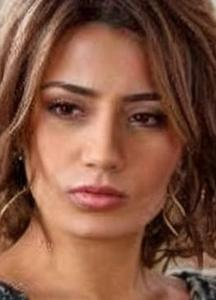

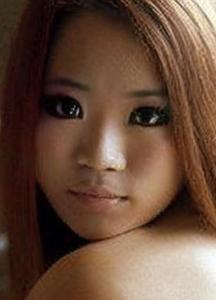

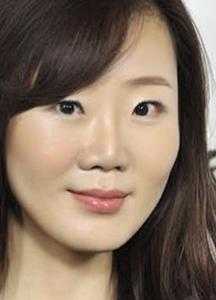

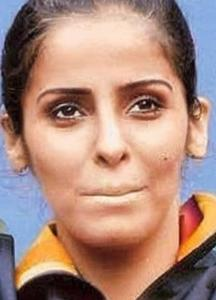

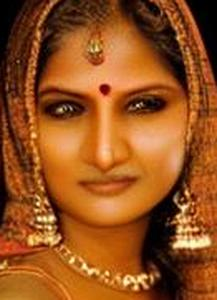

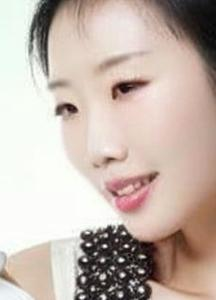

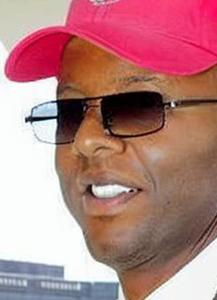

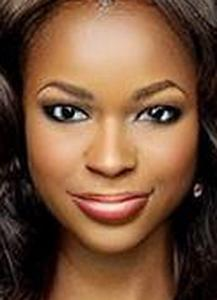

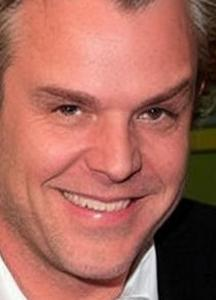

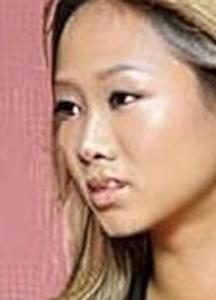

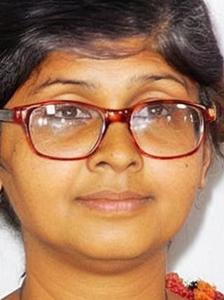

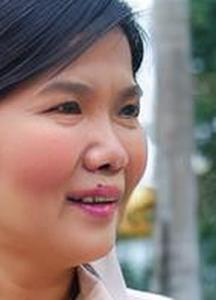

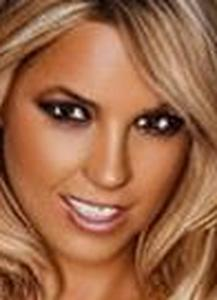

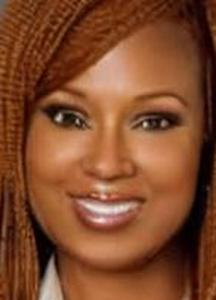

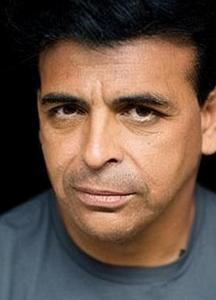

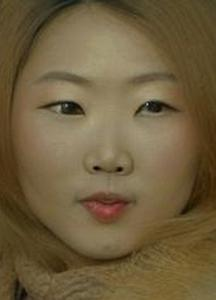

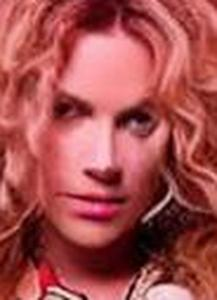

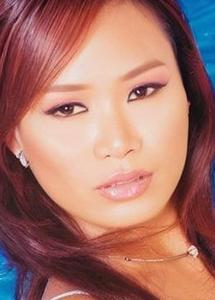

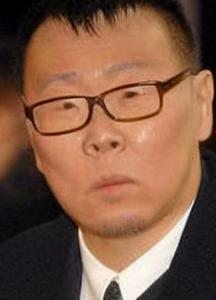

In [ ]:
# from PIL import Image
# import os

# detections_dir = "detected_faces_CelebA_10k_aug_samples_correct_gender/"

# for i, filename in enumerate(os.listdir(detections_dir)):
#     if i <= 20:
#         continue
#     if i == 40:
#         break
#     file_path = os.path.join(detections_dir, filename)
#     with Image.open(file_path) as img:
#             img.show()